In [1]:
using NBInclude
using Plots
using LaTeXStrings
using SparseArrays
using DataFrames
using ProgressBars
using Interpolations
using LinearAlgebra
@nbinclude("Hofstadter Single Particle in Julia.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"))
@nbinclude(joinpath("../Braiding Utils.ipynb"))
@nbinclude("../Aharonov-Bohm Phase.ipynb")
@nbinclude("../Hofstadter Many Body Utils.ipynb");

In [2]:
Nx=25
Ny=15
N=Nx*Ny
p=1
q=5*Ny
NPhi = Int( Nx * Ny * (p/q) )
cut_off = NPhi
PN = [0, 1, 2]
U = 2;

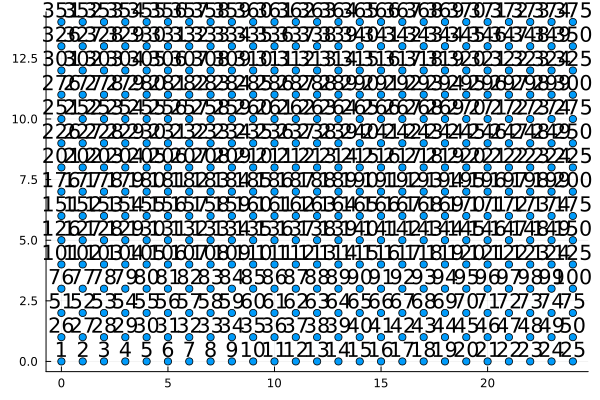

([0 0; 1 0; … ; 23 14; 24 14], nothing)

In [3]:
_, _ = plot_square_lattice(Nx, Ny)

In [4]:
# IMPURITY DATA
V_Strength = 4
V0 = [V_Strength, 0*V_Strength]; Imp_Site = [19, 54]
N_Pin = length(V0[V0 .> 0]) # Number of pinning quasihole

Impurity_Data = Impurity(V0, Imp_Site)
factor = 10 # particle density interpolation factor

# MOVING QUASIHOLES
start_point_1 = Impurity_Data.Imp_Site[1]
lens_1 = [3, 4, 3, 4]
dirs_1 = [1, Nx, -1, -Nx]
rec_path_1 = unique(rectangular_path(start_point_1,lens_1,dirs_1))
rec_path_1 = push!(rec_path_1, start_point_1)

start_point_2 = Impurity_Data.Imp_Site[2]
lens_2 = [3, 4, 3, 4]
dirs_2 = [-1, -Nx, 1, Nx]
rec_path_2 = unique(rectangular_path(start_point_2,lens_2,dirs_2))
rec_path_2 = push!(rec_path_2, start_point_2)

# STEP CONTROL
delta_t = 0.01
STEP = 0:delta_t:1
println("Step size for braiding: ",length(STEP))

Step size for braiding: 101


In [5]:
# AB PHASE
charge = 1/2
number_of_plaq = 3*4
power = N_Pin * (p/q) * charge * number_of_plaq
AB_phase = exp(2*im*pi*power)

0.8763066800438636 + 0.4817536741017153im

0.0%┣                                                ┫ 0/5 [00:00<00:00, -0s/it]
20.0%┣████████▋                                  ┫ 1/5 [00:00<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████████████┫ 5/5 [00:00<00:00, 30it/s]
100.0%┣██████████████████████████████████████████████┫ 5/5 [00:00<00:00, 30it/s]
0.0%┣                                              ┫ 0/375 [00:00<00:00, -0s/it]
100.0%┣███████████████████████████████████████┫ 375/375 [00:00<00:00, 16.7kit/s]
100.0%┣███████████████████████████████████████┫ 375/375 [00:00<00:00, 16.6kit/s]


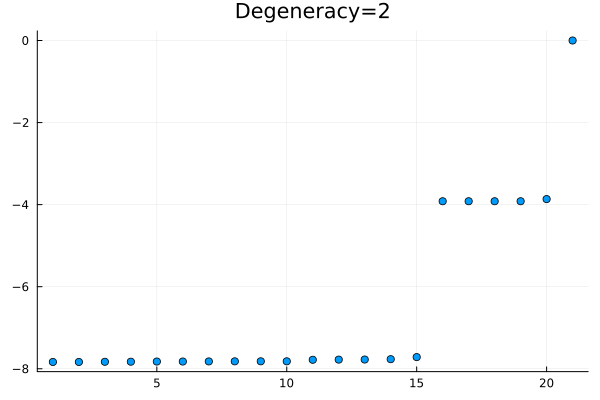

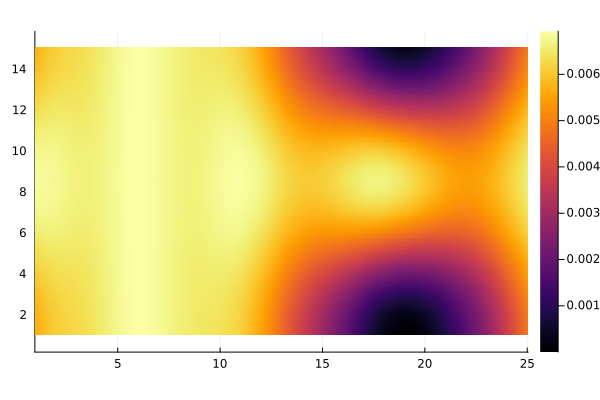

0.0%┣                                             ┫ 0/1.4k [00:00<00:00, -0s/it]


LoadError: BoundsError: attempt to access 375-element Vector{Operator{ManyBodyBasis{Vector{Int64}, NLevelBasis{Int64}, 0x6d009f21f261c8f9, UInt64}, ManyBodyBasis{Vector{Int64}, NLevelBasis{Int64}, 0x6d009f21f261c8f9, UInt64}, SparseMatrixCSC{ComplexF64, Int64}}} at index [-24]

In [6]:
E, Sub_Number_MB_Operator_List, basis_cut_mb, Degeneracy, Eigen_List, BP = Get_AB_Phase(N, Nx, Ny, p, q, cut_off, PN, U, Impurity_Data);

In [7]:
BP

LoadError: UndefVarError: `BP` not defined

In [8]:
scatter(E[1:5])

LoadError: UndefVarError: `E` not defined

In [9]:
length(Eigen_List)

LoadError: UndefVarError: `Eigen_List` not defined

In [127]:
# @gif for i in 1500:1616
#     data = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, Eigen_List[i])'
#     heatmap(Interp(data, factor), aspect_ratio=:equal)
# end